In [1]:
import os

url_path = "https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a05/"
downloads = {"surnames_with_splits.csv.bz2": "surnames_with_splits.csv",
             "nlp.py": None}

for download_name, extract_name in downloads.items():
    if extract_name and os.path.exists(extract_name):
        continue

    if not os.path.exists(download_name):
        import requests
        response = requests.get(f"{url_path}{download_name}")
        with open(download_name, "wb") as fp:
            fp.write(response.content)
        response.close()

    if not extract_name:
        continue

    _, ext = os.path.splitext(download_name)
    if ext == ".bz2":    
        import bz2
        with open(download_name, 'rb') as bzf, open(extract_name, 'wb') as fp:
            fp.write(bz2.decompress(bzf.read()))
    elif ext == ".zip":
        from zipfile import ZipFile
        with ZipFile(download_name) as zf:
            zf.extractall(path=".")


# SOLUTION: Classifying Surnames with a RNN

## Imports

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


from nlp import StepByStep, Vectorizer, Vocabulary
from itertools import chain

def allclose(a, b, atol=1e-4):
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)
    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)
    return torch.allclose(a, b, atol=atol)

## Dataframes

In [3]:
surname_df = pd.read_csv("surnames_with_splits.csv")

train_df = surname_df[surname_df.split == "train"]
val_df = surname_df[surname_df.split == "val"]
test_df = surname_df[surname_df.split == "test"]


## Vocabulary

👍
Create variables:
* `nationality_vocab` as instance of `Vocabulary` filled with nationalities from `train_df`
* `surname_vocab` as instance of `Vocabulary` which is filled with all letters from all surnames in `train_df` and whose special tokens are:
    * pad token = `" "` (space),
    * begin token = `"<"`
    * end token = `">"` 
    * unknown token = `"@"`.
* `max_surname_size` is length of the longest surname in `train_df` increases by **2** (since begin and end tokens are added to padded surname)

In [4]:
nationality_vocab = Vocabulary()
nationality_vocab.fill(surname_df.nationality)

surname_vocab = Vocabulary(pad_tok=".", unk_tok="@", bgn_tok="<", end_tok=">")
surname_vocab.fill(chain(*train_df.surname))
max_surname_size = max(train_df.surname.apply(len)) + 2 # for begin and end tok

# test
assert len(nationality_vocab) == 18

assert max_surname_size == 19
assert torch
assert allclose(surname_vocab.pad("johnson", max_surname_size), [1, 43, 48, 41, 47, 52, 48, 47, 2, 
                                                                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Splitting

For X values surnames are padded accordint to `max_surname_size`.

In [5]:
# datasets
x_train = surname_vocab.pad_many(train_df.surname, size=max_surname_size)
y_train = nationality_vocab.vocabularize(train_df.nationality)

x_val = surname_vocab.pad_many(val_df.surname, size=max_surname_size)
y_val = nationality_vocab.vocabularize(val_df.nationality)

x_test = surname_vocab.pad_many(test_df.surname, size=max_surname_size)
y_test = nationality_vocab.vocabularize(test_df.nationality)

## Class weights

👍
Create variable `class_counts` as dictionary whose keys are countries and values are frequencies of countries in `train_df` dataframe.
Order counts by order of their appearance in `nationality_vocab` vocabulary.

Create variable `y_weight_tensor` whose value is 
$$ \frac{1}{log(freq(nationality))} $$
where $ freq(country) $ is frequency of country in `train_df` dataframe.

Order weights by order of their appearance in `nationality_vocab` vocabulary.

In [6]:
class_counts = train_df.nationality.value_counts().reindex(nationality_vocab).to_dict()
class_counts = {cls: class_counts[cls] 
                for cls in sorted(class_counts, key=nationality_vocab.get)}

y_freq_tensor = torch.zeros(len(class_counts))
for cls, cnt in class_counts.items():
    i = nationality_vocab[cls]
    y_freq_tensor[i] = cnt

y_weight_tensor = 1 / torch.log(y_freq_tensor)

# test
assert class_counts == {'Arabic': 1122, 'Chinese': 154, 'Czech': 289, 'Dutch': 165, 'English': 2080, 'French': 160, 'German': 403, 'Greek': 109, 'Irish': 128, 'Italian': 420, 'Japanese': 542, 'Korean': 53, 'Polish': 84, 'Portuguese': 38, 'Russian': 1661, 'Scottish': 52, 'Spanish': 180, 'Vietnamese': 40}
assert y_weight_tensor.shape == (18,)
assert allclose(y_weight_tensor[:5], [0.1424, 0.1985, 0.1765, 0.1959, 0.1309])

# Plotting frequencies and weights

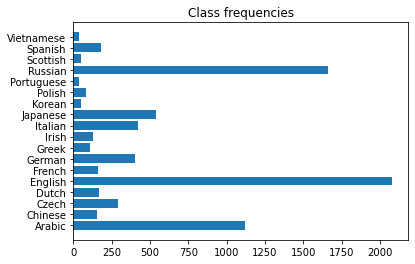

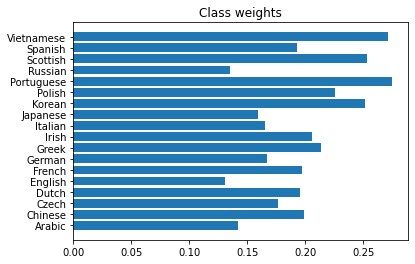

In [7]:
plt.title("Class frequencies")
plt.barh(list(class_counts), class_counts.values())
plt.show()

plt.title("Class weights")
plt.barh(list(class_counts), y_weight_tensor)
plt.show()

## Dataset

In [8]:
class SurnameDataset(Dataset):

    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

## Model overview




### Step 1: Vocabulary

Let vocabulary $V$ contain 25 letters a, b, c, ..., z, and 4 special tokens:
* `'.'` - pad token
* `'<'` - begin of sequence token
* `'>'` - end of token sequence
* `'*'` - unknown token

$V=\{.,<,>,a,b,c,...,z,*\}$

$v_{size} = |V|=25 + 4 = 29$

In [9]:
V = Vocabulary(pad_tok=".", bgn_tok="<", end_tok=">", unk_tok="@")
V.fill("abcdefghijklmnopqrstuvxyz")
v_size = len(V)

print("V =", V)
print("v_size =", v_size)

V = Vocabulary({'.': 0, '<': 1, '>': 2, '@': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'x': 26, 'y': 27, 'z': 28})
v_size = 29


### Step 2: Vectorization with fixed size

Let maximal number of letters in surname $s_{size}$ is 10.

$s_{size} = 10$

Vectorization of the surname 'adams' with padding is

$x = V(adams) = [1, 4, 7, 4, 16, 22, 2, 0, 0, 0]$

In [10]:
surname = "adams"
s_size = 10
x = V.pad(surname, size=s_size)

print("surname =", surname)
print("s_size =", s_size)
print("x =", x.tolist())

surname = adams
s_size = 10
x = [1, 4, 7, 4, 16, 22, 2, 0, 0, 0]


### Step 3: Embedding

Let $E$ be embedding layer having shape $v_{size} \times e_{dim}$ where $e_{dim}$ is 15.

Then $e_x = E(x)$ is embedding vector of the surname 'adams' and shape of $e_x$ is $s_{size} \times e_{dim}$


In [11]:
e_dim = 15
E = nn.Embedding(num_embeddings=v_size, embedding_dim=e_dim, padding_idx=0)
e_x = E(x)

print("E shape =", tuple(E.weight.shape))
print("e_x shape =", tuple(e_x.shape))

E shape = (29, 15)
e_x shape = (10, 15)


### Step 4: RNN

Let RNN has input dimension of $e_{dim}$ and hidden dimension $h_{dim}$ = 4.

Forward propagation of $x$ and first hidden vector $h_0 = [0, 0, 0, 0]$ is

$h_{all}, h_{s_{size}}=RNN(x, h_0)$

where $h_{all}$ contains all activations in time including the last activation $h_{s_{size}}$.


In [12]:
h_dim = 4
h_0 = torch.zeros(1, h_dim) # torch requires that h_0 is in batch
R = nn.RNN(input_size=e_dim, hidden_size=4, batch_first=True)
h_all, h_s_size = R(e_x, h_0)

print("h_dim =", h_dim)
print("h_0 =", h_0.tolist())

print("h_all shape =", tuple(h_all.shape))
print("h_s_size shape =", tuple(h_s_size.shape))
print("last row in h_all =", h_all[-1].tolist())
print("h_s_size =", h_s_size.tolist())



h_dim = 4
h_0 = [[0.0, 0.0, 0.0, 0.0]]
h_all shape = (10, 4)
h_s_size shape = (1, 4)
last row in h_all = [-0.4956362247467041, 0.570721447467804, -0.357920378446579, -0.3135487735271454]
h_s_size = [[-0.4956362247467041, 0.570721447467804, -0.357920378446579, -0.3135487735271454]]


### Step 5: Two Linear layers

Let $FC1$ is linear layer of shape $h_{dim} \times h_{dim}$.

Let $c_{dim}$ be an size of an output (number of classes)

Let $FC2$ is linear layer of shape $h_{dim} \times c_{dim}$.

Then 

$\hat{y} = FC2(ReLU(FC1(h_{s_{size}})))$

In [13]:
c_dim = 3
FC1 = nn.Linear(in_features=h_dim, out_features=h_dim)
FC2 = nn.Linear(in_features=h_dim, out_features=c_dim)

y_hat = FC2(F.relu(FC1(h_s_size.squeeze())))

print("y_hat shape =", tuple(y_hat.shape))


y_hat shape = (3,)


## The Model: SurnameClassifier

👍 Create `SurnameClassifier` class as RNN width following methods:

Method `__init__(self, num_emb, emb_size, rnn_hidden_size, num_classes, batch_first=True, padding_idx=0)` initializes classifier with
* `num_emb` - number of embeddings is $v_{size}$
* `emb_size` - dimension of embedding is $e_{dim}$
* `rnn_hidden_size` - dimension of hidden layer of RNN is $h_{dim}$
* `num_classes` - dimension of output (number of classes) is $c_{dim}$

Crete layers according to Model overview presented in the cells above.

Method `forward(self, x, apply_softmax=False)` for forward propagation according to Model overciew presented in the cells above.

NOTE: Use dropout with $p=0.5$ for all inputs into each fully connected layer.

In [14]:
class SurnameClassifier(torch.nn.Module):
    def __init__(self, 
                 num_emb, emb_size,
                 rnn_hidden_size,
                 num_classes, 
                 batch_first=True, padding_idx=0):
                 
        super(SurnameClassifier, self).__init__()
        self.batch_first = batch_first

        self.emb = torch.nn.Embedding(num_embeddings=num_emb,
                                      embedding_dim=emb_size,
                                      padding_idx=padding_idx)

        self.rnn = torch.nn.RNN(input_size=emb_size, 
                                hidden_size=rnn_hidden_size,
                                batch_first=batch_first)

        self.fc1 = torch.nn.Linear(in_features=rnn_hidden_size,
                                   out_features=rnn_hidden_size)

        self.fc2 = torch.nn.Linear(in_features=rnn_hidden_size,
                                   out_features=num_classes)


    def forward(self, x, apply_softmax=False):        
        batch_size, seq_size  = x.shape

        x_emb = self.emb(x)

        zero_hidden = torch.zeros(1, batch_size if self.batch_first else seq_size, self.rnn.hidden_size)
        y_hat, next_hidden = self.rnn(x_emb, zero_hidden)

        y_hat = y_hat[:,-1,:] # keep the last hidden state for each batch 
        #y_hat = next_hidden.squeeze() # is same as upper way

        y_hat = F.relu(self.fc1(F.dropout(y_hat, 0.5)))
        y_hat = self.fc2(F.dropout(y_hat, 0.5))
        
        if apply_softmax:
            y_hat = F.softmax(y_hat, dim=1)
        return y_hat    


# test
StepByStep.set_seed(96)
model = SurnameClassifier(num_emb=len(surname_vocab), 
                          emb_size=100,
                          rnn_hidden_size=64,
                          num_classes=len(nationality_vocab),
                          padding_idx=surname_vocab[surname_vocab.pad_tok], batch_first=False)
layers = list(model.children())
assert len(layers) == 4
assert isinstance(layers[0], nn.Embedding)
assert isinstance(layers[1], nn.RNN)
assert isinstance(layers[2], nn.Linear)
assert isinstance(layers[3], nn.Linear)
dataset = SurnameDataset(x_train, y_train)
loader = DataLoader(dataset, batch_size=3, shuffle=False)
x, y = next(iter(loader))
y_hat = model(x)
assert y_hat.shape == (3, 18)
assert allclose(y_hat.mean(), -0.0136)
assert allclose(y_hat.sum(dim=1), [-0.4314,  0.0830, -0.3875])
y_hat = model(x, apply_softmax=True)
assert y_hat.shape == (3, 18)
assert allclose(y_hat.sum(dim=1), [1., 1., 1.])
del layers, dataset, loader, x, y, y_hat, model

# Train

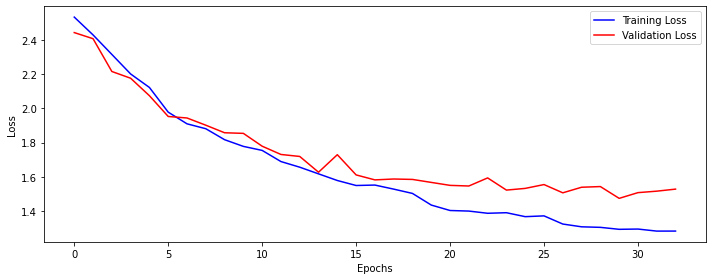

In [15]:
StepByStep.set_seed(96)

model = SurnameClassifier(num_emb=len(surname_vocab), 
                          emb_size=100,
                          rnn_hidden_size=64,
                          num_classes=len(nationality_vocab),
                          padding_idx=surname_vocab[surname_vocab.pad_tok], batch_first=True)

loss_fn = nn.CrossEntropyLoss(y_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_loader = DataLoader(SurnameDataset(x_train, y_train), batch_size=64, drop_last=True, shuffle=True)
val_loader = DataLoader(SurnameDataset(x_val, y_val), batch_size=64, drop_last=True, shuffle=True)

sbs = StepByStep(model, loss_fn, optimizer, scheduler)
sbs.set_loaders(train_loader, val_loader)

sbs.train_by_loss_change(1e-3)

sbs.plot_losses(ylog=False)


### Accuracy

In [16]:
# accuracy
(sbs.predict(x_test).argmax(dim=1) == y_test).sum() / y_test.shape[0]

tensor(0.6319)

## Test

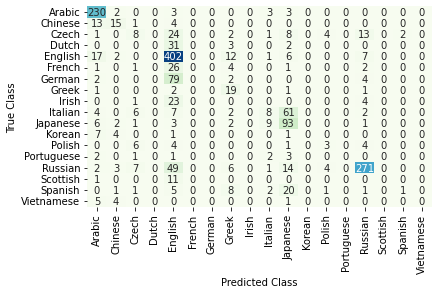

In [17]:
y_pred = sbs.model(x_test, apply_softmax=True).argmax(dim=1)

labels = list(nationality_vocab)

confusion = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(confusion, index=labels, columns=labels)
#conf_df[conf_df==0] = ""

sns.heatmap(conf_df, annot=True, cbar=None, cmap="GnBu", fmt="d")
plt.tight_layout()
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()
#confusion_matrix(y_test, y_pred)

### Inference

In [18]:
def predict_nationality(surname, model, surname_vocab, nationality_vocab):
    x = surname_vocab.pad(surname, max_surname_size).unsqueeze(0)
    y_pred = model(x, apply_softmax=True)
    i = y_pred.argmax(dim=1).item()
    nationality = nationality_vocab.inv[i]
    return nationality

predict_nationality("Trump", sbs.model, surname_vocab, nationality_vocab)

'English'

### Top-K Inference

In [19]:
def predict_topk_nationality(surname, model, surname_vocab, nationality_vocab, k=5):
    x = surname_vocab.pad(surname, max_surname_size).unsqueeze(0)
    y_pred = model(x, apply_softmax=True)

    probs, indices = torch.topk(y_pred, k=k)
    probs = probs.squeeze().tolist()
    indices = indices.squeeze().tolist()

    nationalities = {}
    print(f"Top {k} predictions:")
    for i, p in zip(indices, probs):
        nationality = nationality_vocab.inv[i]
        nationalities[nationality] = p
        print(f"{surname} => {nationality} (p={p:.3f})")

    return nationalities

predict_topk_nationality("Malkovich", sbs.model, surname_vocab, nationality_vocab, k=5)

Top 5 predictions:
Malkovich => Russian (p=0.891)
Malkovich => English (p=0.036)
Malkovich => Czech (p=0.028)
Malkovich => Irish (p=0.021)
Malkovich => Scottish (p=0.009)


{'Russian': 0.8908973336219788,
 'English': 0.03584690019488335,
 'Czech': 0.027926897630095482,
 'Irish': 0.020813651382923126,
 'Scottish': 0.008632159791886806}